In [1]:
import pandas as pd
import numpy as np
#import graphlab as tc
import turicreate as tc
from tqdm.notebook import tqdm
import turicreate.aggregate as agg
from sklearn.model_selection import train_test_split
from numpy.random import default_rng

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
import pickle
import matplotlib.pyplot as plt

In [2]:
# alt distance
mlong = pd.read_csv('../data/joined.csv', index_col='apn')
mlong['nf'] = mlong['nf'].apply(eval)
def jaccard(apid1: int, apid2: int, funcs) -> float:
    p1 = funcs[apid1]
    p2 = funcs[apid2]

    return 1 - len(p1 & p2)/len(p1|p2)

# good old panda based distance calculation:
distance = lambda x,y: jaccard(x, y, mlong['nf'])

In [3]:
mw = tc.load_sframe('../binarydata/funcs-encoded')
mw = mw.remove_column('fcount', inplace=True)

In [3]:
test_apns = np.load('../res/test-tc-1000.npy')

In [4]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [5]:
gamma = 0.6666666666666666
ref, mer = nets[gamma]

In [30]:
## recommender for all exclude test from similar items?

In [12]:
from streamed import tc_based_nn

def s_conver_to_probs(v):
    return 1.0 - v[1]/(v[0]+v[1])

def eval_net(net, test_apns, data):
    nns = tc_based_nn(net, list(test_apns), data)
    return [s_conver_to_probs(net[row['nn']]) for row in nns.sort('apk')]

In [81]:
nns = tc_based_nn(ref, list(test_apns), mw)

nns.head()

apk,nn
26561,3
16257,20486
12088,3
2464,9218
26001,3
19279,11
18741,18454
18939,2074
21368,3
11452,20486


In [105]:
## full prediction

In [384]:
res = dict()
res_mer = dict()

#sorting to keep the results consistent (probs matching true values)
test_apns.sort()
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]


for gamma, [ref, mer] in tqdm(nets.items()):
    res[gamma] = [eval_net(net=ref, test_apns=test_apns, data=mw), true_values]
    res_mer[gamma] = [eval_net(net=mer, test_apns=test_apns, data=mw), true_values]
    

  0%|          | 0/19 [00:00<?, ?it/s]

In [385]:
with open('../res/tc-new-res.pickle', 'wb+') as f:
    pickle.dump(res, f)

with open('../res/tc-new-mer.pickle', 'wb+') as f:
    pickle.dump(res_mer, f)

In [163]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]

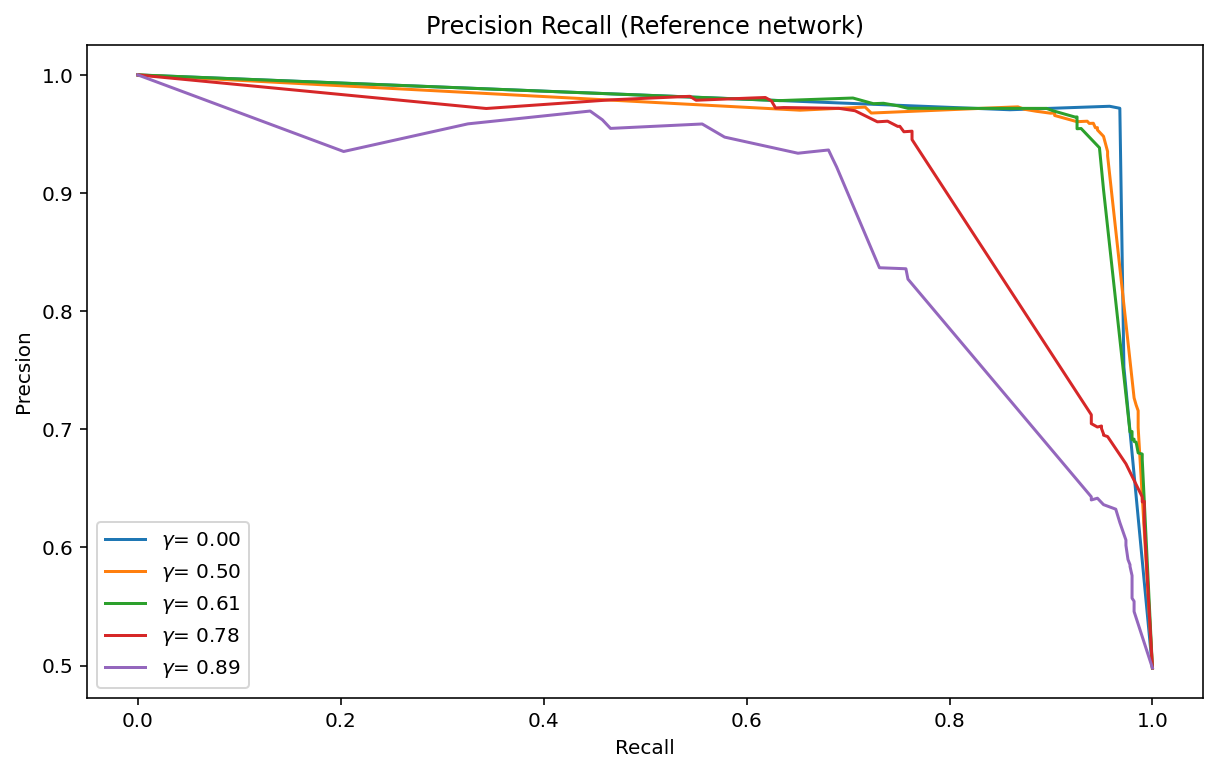

In [172]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Reference network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();

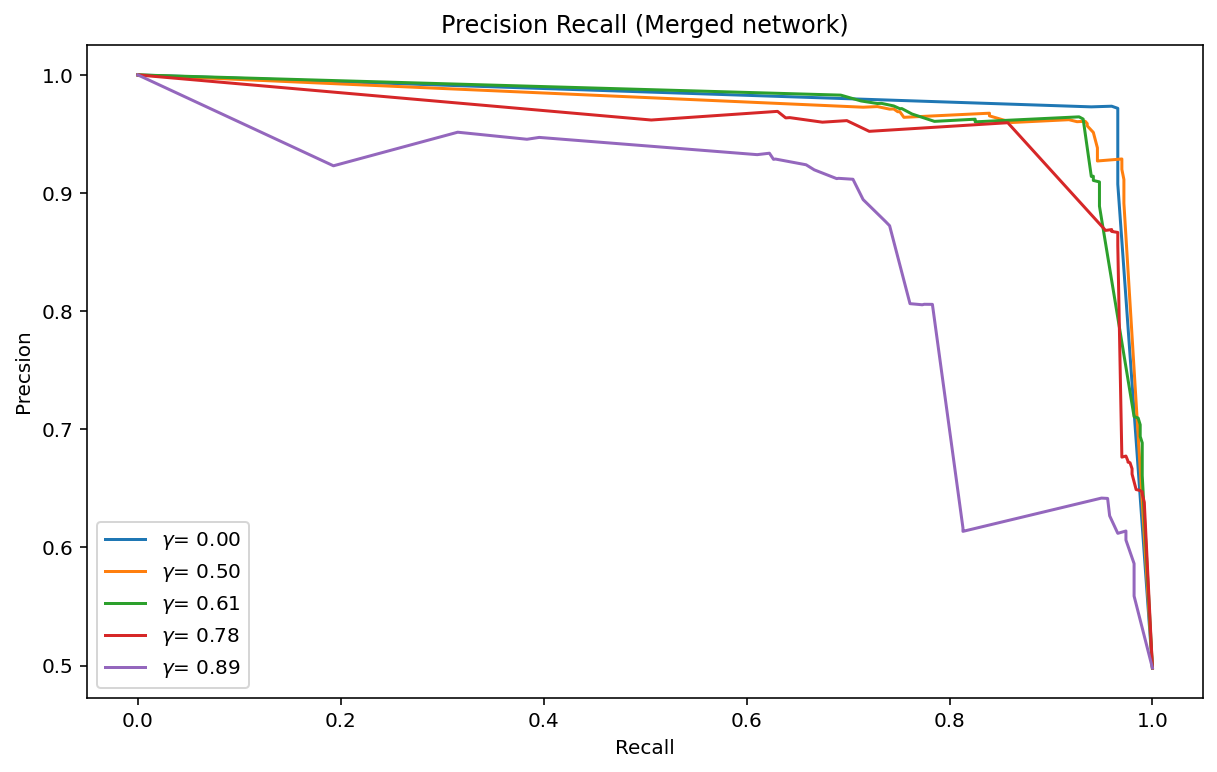

In [171]:
plt.figure(figsize=(10,6))
plt.title('Precision Recall (Merged network)')
plt.xlabel('Recall')
plt.ylabel('Precsion')
for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs)
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f}")
plt.legend();
# AuC

In [183]:
# compression
d_size = sum(map(sum, mer.values()))

compr = dict()
for gamma, [ref, mer] in nets.items():
    compr[gamma] = [len(ref)/d_size, len(mer) /d_size]

df = pd.DataFrame.from_dict(compr, orient='index', columns=['ref', 'mer'])

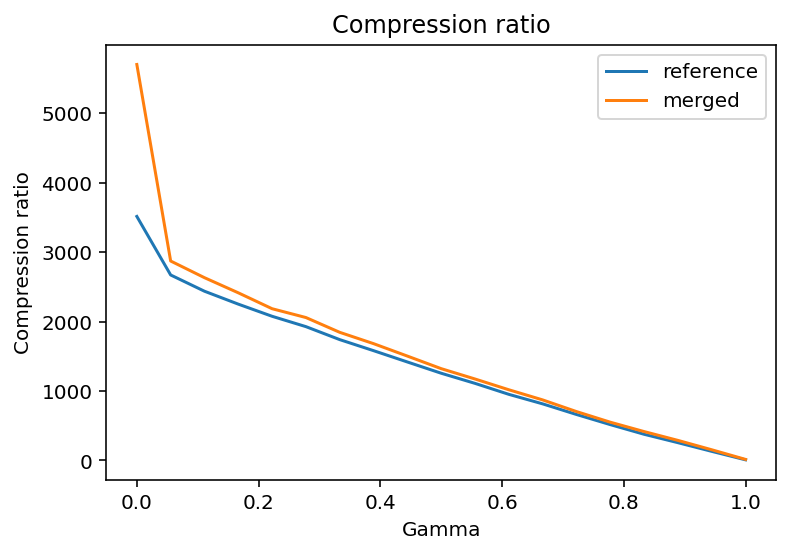

In [245]:
plt.title("Compression ratio ")
plt.plot(df.ref*d_size, label='reference')
plt.plot(df.mer*d_size, label='merged')
plt.xlabel('Gamma')
plt.ylabel('Compression ratio')
plt.legend();

In [430]:
from scipy.stats import linregress

In [439]:
comp_mer = {gamma: len(voting) for gamma, [merged, voting] in nets.items()}

In [442]:

res = linregress(list(comp_mer.keys())[1:], list(comp_mer.values())[1:])
print(res)


LinregressResult(slope=-2972.6377708978325, intercept=2884.836601307189, rvalue=-0.9972534373717314, pvalue=1.614141302623645e-19, stderr=55.19348288747532, intercept_stderr=33.19077036024268)


In [449]:
np.array(list(comp_mer.keys()))

array([0.        , 0.05555556, 0.11111111, 0.16666667, 0.22222222,
       0.27777778, 0.33333333, 0.38888889, 0.44444444, 0.5       ,
       0.55555556, 0.61111111, 0.66666667, 0.72222222, 0.77777778,
       0.83333333, 0.88888889, 0.94444444, 1.        ])

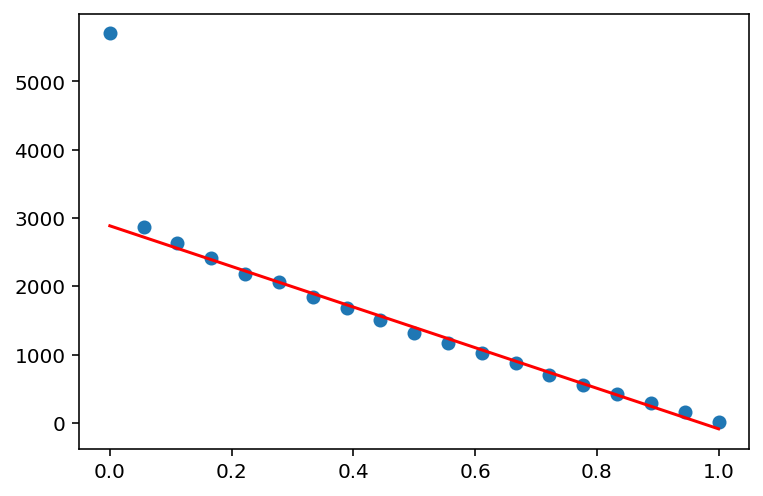

In [450]:
x = np.array(list(comp_mer.keys()))
y = list(comp_mer.values())

plt.plot(x, y, 'o')
plt.plot(x, res.intercept + res.slope*x, 'r', label='fitted line')


## TODOs
1. AuC to actually compare the merged and reference network
1. slope of the compression curve
1. debug the netowrk creation strange results
1. streaming-based creation

### Streaming-based creation
1. partition data,
1. create network for the first partition
1. use their anchors to calculate (update) networks for other
- prediction?
1. merge (concatation)

In [320]:
## stream eval

In [25]:
with open('../res/9003-stream-nets.pickle', 'rb') as f:
    st_nets = pickle.load(f)

In [26]:
with open('../res/9003-new-stream-nets.pickle', 'rb') as f:
    stn_nets = pickle.load(f)

In [27]:
for gamma, [merged, voting] in stn_nets.items():
    print(gamma, sum(map(sum, voting.values())))

0.0 9003
0.05555555555555555 9003
0.1111111111111111 9003
0.16666666666666666 9003
0.2222222222222222 9003
0.2777777777777778 9003
0.3333333333333333 9003
0.3888888888888889 9003
0.4444444444444444 9003
0.5 9003
0.5555555555555556 9003
0.6111111111111112 9003
0.6666666666666666 9003
0.7222222222222222 9003
0.7777777777777778 9003
0.8333333333333334 9003
0.8888888888888888 9003
0.9444444444444444 9003
1.0 8997


In [326]:
gamma = 0.6666666666666666

In [327]:
[merged, voting]  = st_nets[gamma]

In [31]:
test_apns.sort()
labels = pd.read_csv('../data/labels_encoded.csv', index_col=0)
true_values = [not labels.loc[a]['malware_label'] for a in test_apns]

In [39]:
probs = dict()
for gamma, [merged, voting] in tqdm(stn_nets.items()):
    probs[gamma] = eval_net(net=voting, test_apns=test_apns, data=mw)

  0%|          | 0/19 [00:00<?, ?it/s]

In [40]:
with open('../res/tc-stream-new-probs.pickle', 'wb+') as f:
    pickle.dump(probs, f)


In [41]:
gammas = [0.0, 0.5, 0.6111111111111112, 0.7777777777777778, 0.8888888888888888]
plt.figure(figsize=(10,8))
for gamma in gammas:
    [precisons, recalls, thresholds] = precision_recall_curve(true_vals, probs[gamma])
    roc_auc = metrics.roc_auc_score(true_vals, probs[gamma])
    plt.plot(recalls, precisons, label=f"$\gamma$= {gamma:.2f} (auc={roc_auc:.2f})")
plt.legend();

NameError: name 'true_vals' is not defined

<Figure size 720x576 with 0 Axes>

In [8]:
# auc
from sklearn import metrics

In [370]:
gamma = 0.8888888888888888
metrics.roc_auc_score(true_vals, probs[gamma]) 


0.9034244547912766

In [359]:
size = sum(map(sum, st_nets[0.0][1].values()))
comp = {gamma: len(voting) for gamma, [merged, voting] in st_nets.items()}

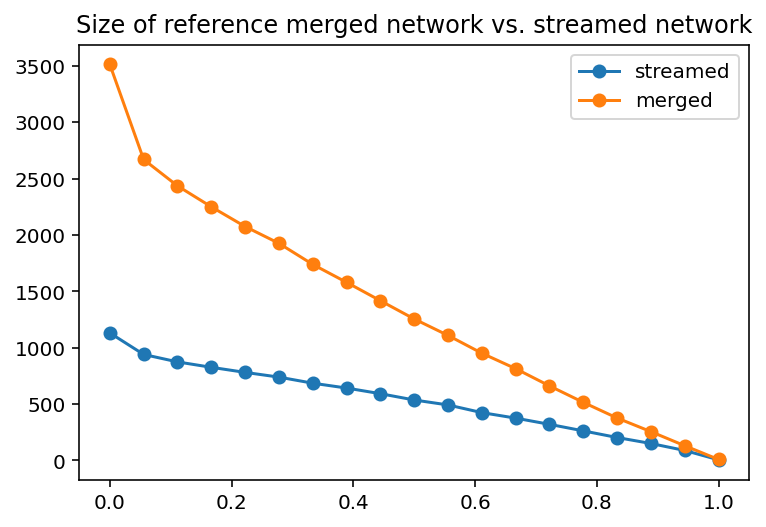

In [361]:
plt.title('Size of reference merged network vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(df.ref*d_size, '-o', label='merged')
plt.legend();

In [356]:
single_nets = dict()
for gamma in st_nets.keys():
    with open(f"../res/{gamma}-tc-singlevoting.pickle", 'rb') as f:
        nw = pickle.load(f)
        single_nets[gamma] = nw[gamma]

In [358]:
single_sizes = {g:len(a[0]) for g, a in single_nets.items()}

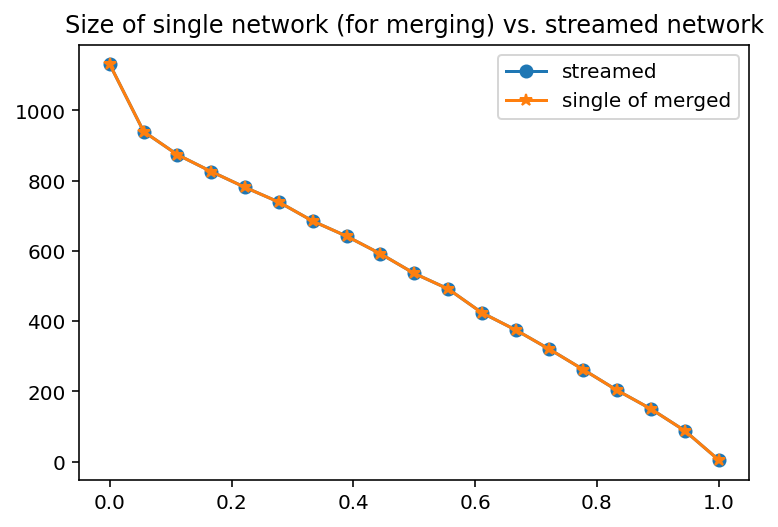

In [363]:
plt.title('Size of single network (for merging) vs. streamed network')
plt.plot(list(comp.keys()), list(comp.values()),'-o', label='streamed')
plt.plot(list(single_sizes.keys()), list(single_sizes.values()), '-*', label='single of merged')
plt.legend();

In [378]:
# Precision comprarision between streamed and merged

In [388]:
with open('../res/tc-new-mer.pickle', 'rb') as f:
    res_mer = pickle.load(f)

with open('../res/tc-stream-probs.pickle', 'rb') as f:
    res_str = pickle.load(f)

In [405]:
gammas = list(res_mer.keys())[:-1]
to_plot=dict()

for gamma in gammas:
    probs, true_vals = res_mer[gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, res_str[gamma])
    roc_auc1 = metrics.roc_auc_score(true_vals, probs) 
    
    [p2, r2, thresholds] = precision_recall_curve(true_vals, probs)
    roc_auc2 = metrics.roc_auc_score(true_vals, res_str[gamma])

    to_plot[gamma] = [p1, r1, roc_auc1, p2, r2, roc_auc2]

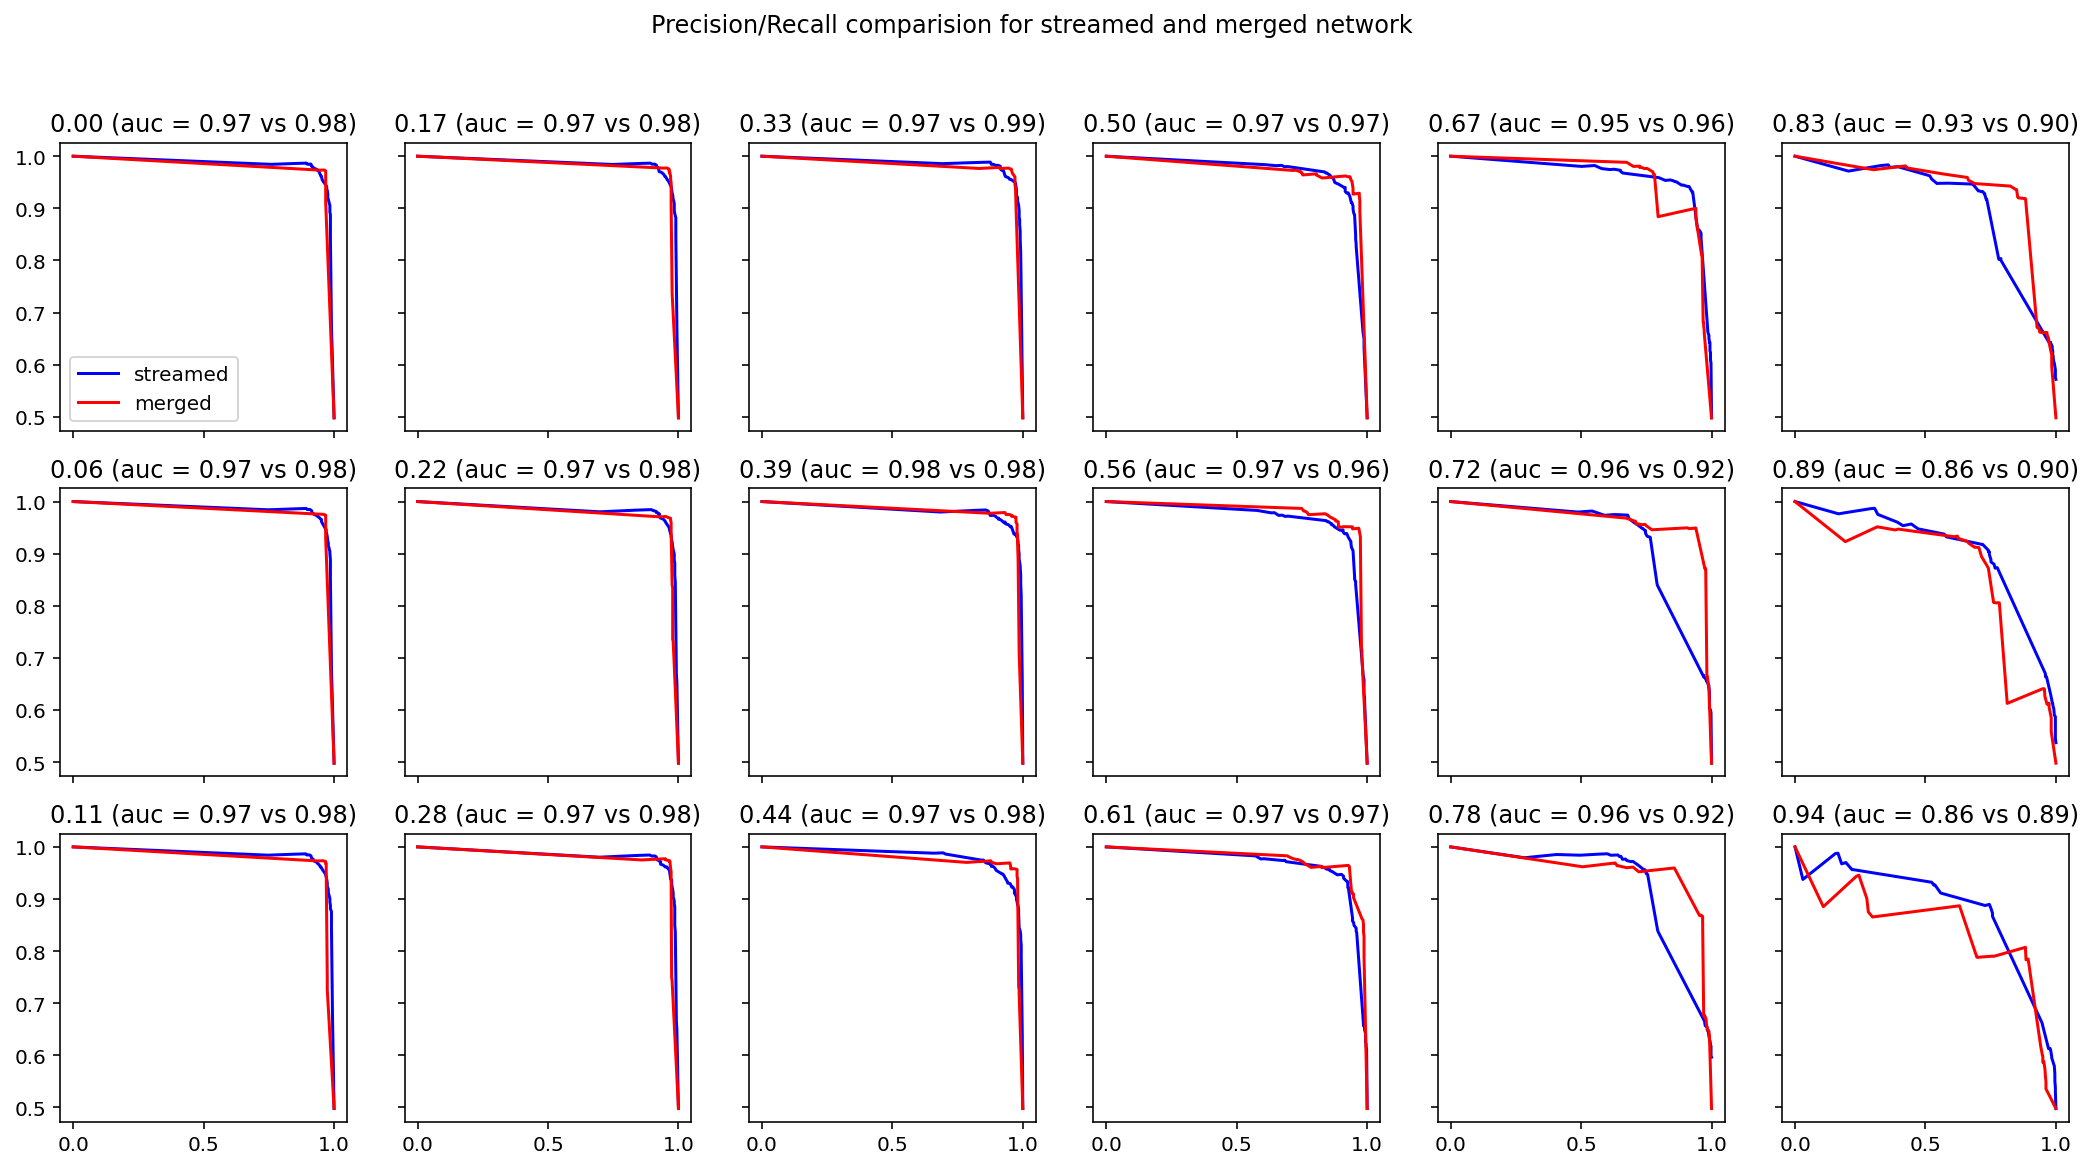

In [429]:
rows = 3
cols = 6

fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True, sharey=True)
fig.suptitle('Precision/Recall comparision for streamed and merged network')
for i, gamma in enumerate(to_plot.keys()):
    [p1, r1, roc_auc1, p2, r2, roc_auc2] = to_plot[gamma]
    axs[i%rows, i//rows].plot(r1, p1, c='b', label='streamed')
    axs[i%rows, i//rows].plot(r2, p2, c='r', label='merged')
    axs[i%rows, i//rows].set_title(f"{gamma:.2f} (auc = {roc_auc1:.2f} vs {roc_auc2:.2f})")

axs[0,0].legend();

In [3]:
net_file = '../res/9003-tc-jaccard-votingnets.pickle'
with open(net_file, 'rb') as f:
    nets = pickle.load(f)

In [21]:
with open('../res/new-9003-tc-jaccard-votingnets.pickle', 'rb') as f:
    new_nets = pickle.load(f)

with open('../res/3pass-9003-tc-jaccard-votingnets.pickle', 'rb') as f:
    new3_nets = pickle.load(f)



In [22]:
rr = dict()
for gamma, [mer, ref] in nets.items():
    new_mer, new_ref = new_nets[gamma]
    new3_mer, new3_ref = new3_nets[gamma]
    rr[gamma] = [len(mer), len(new_mer), len(new3_mer),len(ref), len(new_ref),len(new3_ref) ]
    print("%.2f" % gamma, rr[gamma])

0.00 [3513, 3513, 3513, 5701, 3513, 3513]
0.06 [2670, 2670, 2670, 2871, 2672, 2672]
0.11 [2436, 2436, 2436, 2631, 2448, 2448]
0.17 [2250, 2250, 2250, 2413, 2262, 2262]
0.22 [2075, 2075, 2075, 2184, 2084, 2084]
0.28 [1926, 1926, 1926, 2057, 1937, 1937]
0.33 [1739, 1739, 1739, 1844, 1762, 1762]
0.39 [1580, 1580, 1580, 1681, 1601, 1601]
0.44 [1417, 1417, 1417, 1502, 1441, 1441]
0.50 [1255, 1255, 1255, 1321, 1269, 1269]
0.56 [1109, 1109, 1109, 1172, 1134, 1134]
0.61 [951, 951, 951, 1017, 980, 980]
0.67 [814, 814, 814, 871, 835, 835]
0.72 [661, 661, 661, 703, 686, 686]
0.78 [515, 515, 515, 550, 526, 526]
0.83 [376, 376, 376, 415, 403, 403]
0.89 [255, 255, 255, 288, 267, 267]
0.94 [130, 130, 130, 153, 137, 137]
1.00 [8, 8, 8, 14, 9, 9]


In [23]:
df = pd.DataFrame.from_dict(rr, orient='index', columns=['mer', 'new_mer','new3_mer', 'ref', 'new_ref', 'new3_ref'])

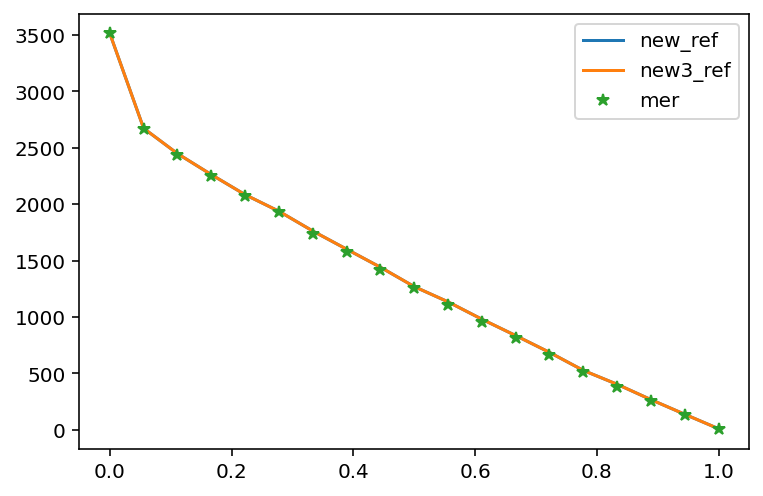

In [24]:
#plt.plot(df.ref, label='ref')
plt.plot(df.new_ref, label='new_ref')
plt.plot(df.new3_ref, label='new3_ref')
plt.plot(df.mer,'*', label='mer')
plt.legend()

# New results

In [3]:
! ls -altr ../res/probs* | tail

-rw-r--r--  1 jj  staff  180866 Nov 27 16:58 ../res/probs.pickle
-rw-r--r--  1 jj  staff  331583 Feb 18 11:52 ../res/probs-merged-th15_merged.pickle
-rw-r--r--  1 jj  staff  172388 Feb 18 12:42 ../res/probs-stream-th15.pickle
-rw-r--r--  1 jj  staff  172397 Feb 18 13:24 ../res/probs-ref-th15.pickle


In [3]:
with open('../res/probs-merged-th15_merged.pickle', 'rb') as f:
    merged_probs = pickle.load(f)
    
with open('../res/probs-stream-th15.pickle', 'rb') as f:
    stream_probs = pickle.load(f)
    
with open('../res/probs-ref-th15.pickle', 'rb') as f:
    ref_probs = pickle.load(f)

In [5]:
# new results
with open('../res/newres/probs_new_merged.pickle', 'rb') as f:
    merged_probs = pickle.load(f)
    
with open('../res/newres/probs-new-streamed.pickle', 'rb') as f:
    stream_probs = pickle.load(f)
    
with open('../res/newres/probs_new_ref.pickle', 'rb') as f:
    ref_probs = pickle.load(f)

In [6]:
gammas = list(ref_probs.keys())[:-1]
to_plot=dict()

for gamma in gammas:
    probs, true_vals = ref_probs[gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, probs)
    auc1 = auc(r1, p1)
    
    probs, true_vals = merged_probs[gamma]
    [p2, r2, thresholds] = precision_recall_curve(true_vals, probs)
    auc2 = auc(r2, p2)
    
    probs, true_vals = stream_probs[gamma]
    [p3, r3, thresholds] = precision_recall_curve(true_vals, probs)
    auc3 = auc(r3, p3)
    
    

    to_plot[gamma] = [p1, r1, auc1, p2, r2, auc2, p3, r3, auc3]

In [7]:
import matplotlib as mpl

mpl.use('svg')
new_rc_params = {
    "font.family": 'Times', #probably python doesn't know Times, but it will replace it with a different font anyway. The final decision is up to the latex document anyway
    "font.size": 14, #choosing the font size helps latex to place all the labels, ticks etc. in the right place
    "font.serif": [],
    "svg.fonttype": 'none',
    "lines.linewidth":2,
"lines.color":'k'} #to store text as text, not as path
mpl.rcParams.update(new_rc_params)

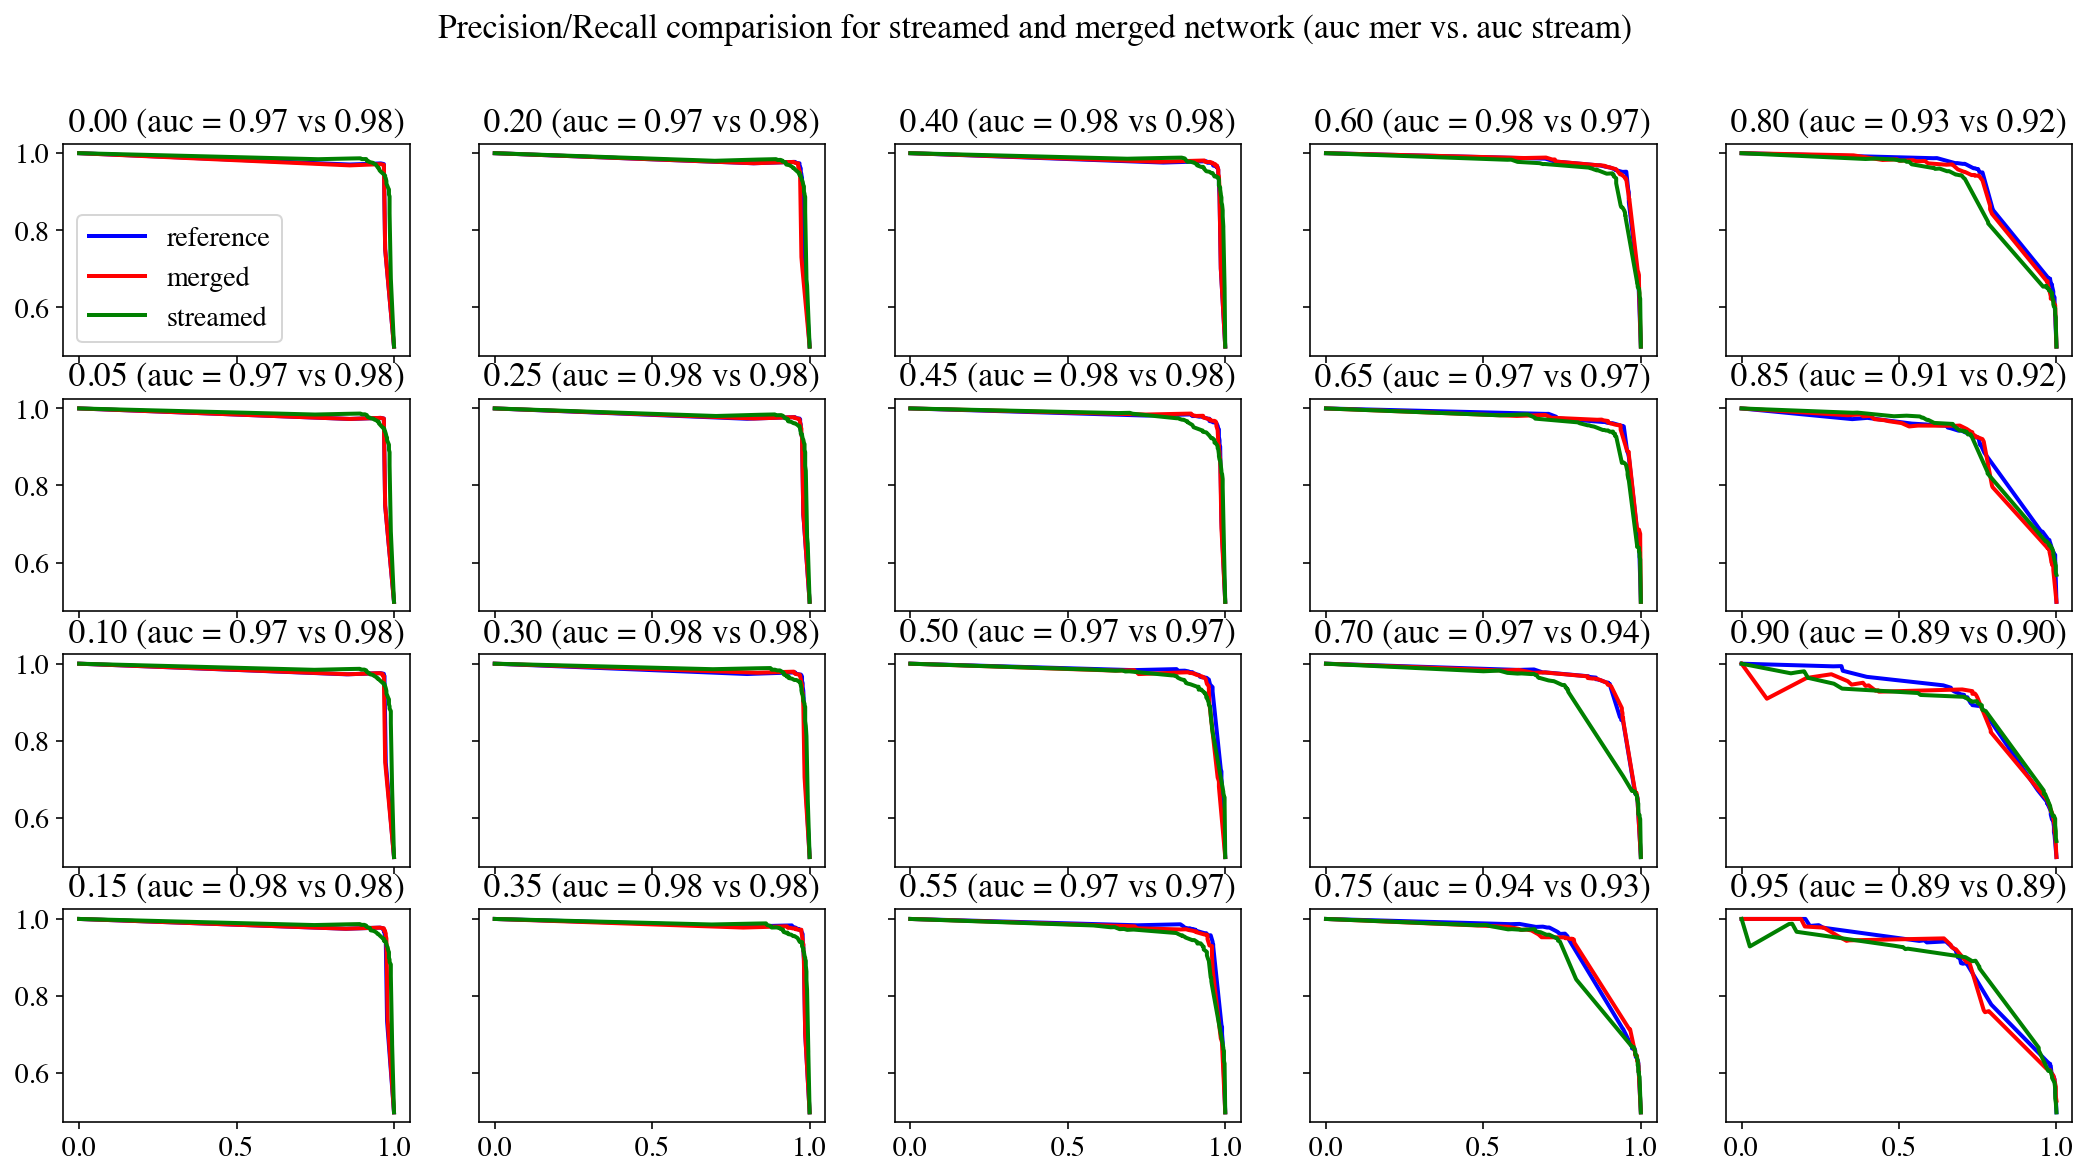

In [8]:
rows = 4
cols = 5

fig, axs = plt.subplots(rows, cols, figsize=(18, 9), sharex=True, sharey=True)
fig.suptitle('Precision/Recall comparision for streamed and merged network (auc mer vs. auc stream)')
for i, gamma in enumerate(to_plot.keys()):
    [p1, r1, auc1, p2, r2, auc2, p3, r3, auc3] = to_plot[gamma]
    axs[i%rows, i//rows].plot(r1, p1, c='b', label='reference')
    axs[i%rows, i//rows].plot(r2, p2, c='r', label='merged')
    axs[i%rows, i//rows].plot(r3, p3, c='g', label='streamed')
    axs[i%rows, i//rows].set_title(f"{gamma:.2f} (auc = {auc2:.2f} vs {auc3:.2f})")

axs[0,0].legend();

In [10]:
aucs = dict()
for gamma, [p1, r1, auc1, p2, r2, auc2, p3, r3, auc3]  in to_plot.items():
    aucs[gamma] = [auc1, auc2, auc3]

df = pd.DataFrame.from_dict(aucs, orient='index', columns=['auc_ref', 'auc_mer', 'auc_stream'])

In [11]:
df

,auc_ref,auc_mer,auc_stream
0.00,0.973198,0.972007,0.983472
0.05,0.974305,0.974305,0.983427
0.10,0.974628,0.974102,0.984404
0.15,0.976995,0.977731,0.984534
0.20,0.976920,0.974779,0.981025
0.25,0.976248,0.976830,0.981666
0.30,0.978113,0.979324,0.984361
0.35,0.982028,0.980187,0.984546
0.40,0.979196,0.980335,0.984902
0.45,0.982307,0.983266,0.980796


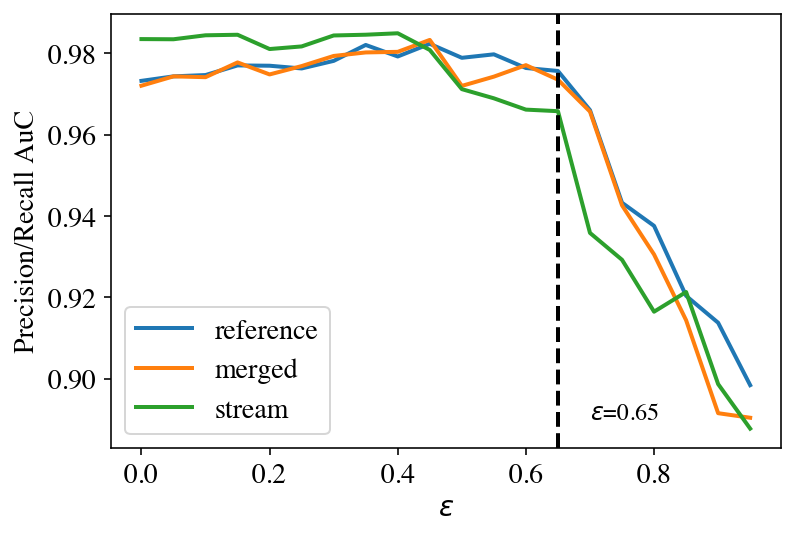

In [12]:
gamma = 0.65
#plt.title('Precision/Recall AuC')
plt.plot(df.auc_ref, label='reference')
plt.plot(df.auc_mer, label='merged')
plt.plot(df.auc_stream, label='stream')

plt.xlabel("$\epsilon$")
plt.legend()
plt.axvline(x=gamma, ls='--', label='')
plt.text(.7, .89, f"$\epsilon$={gamma:.2f}", style='italic', fontsize=12)
plt.ylabel('Precision/Recall AuC');


plt.savefig('../fig/prreauc.svg', format='svg', bbox_inches = 'tight', dpi=1000)

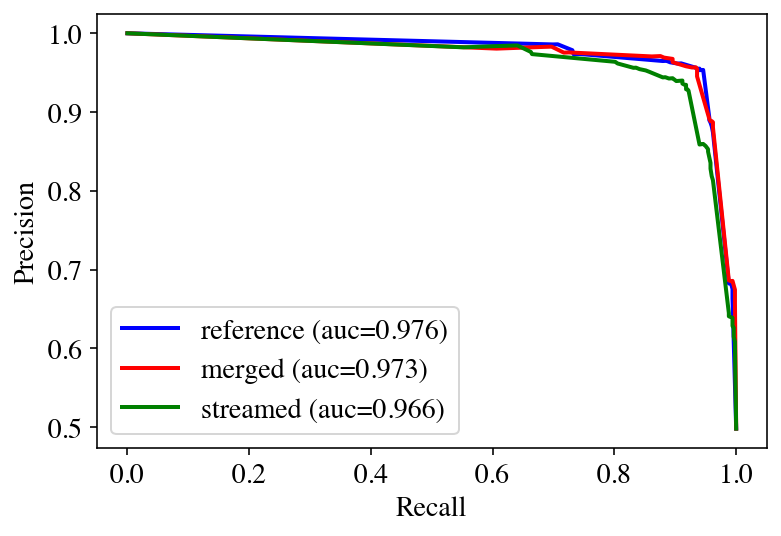

In [13]:
# probably the last good one:
gamma = 0.65
plt.plot(figsize=(12,8))
#plt.title(f"Precision/recall plot $\epsilon$={gamma:.2f}")
plt.xlabel('Recall')
plt.ylabel('Precision')
[p1, r1, auc1, p2, r2, auc2, p3, r3, auc3] = to_plot[gamma]
plt.plot(r1, p1, c='b', label=f"reference (auc={auc1:.3f})")
plt.plot(r2, p2, c='r', label=f"merged (auc={auc2:.3f})")
plt.plot(r3, p3, c='g', label=f"streamed (auc={auc3:.3f})")
plt.legend(fancybox=True);
plt.savefig('../fig/prrec06.svg', format='svg', bbox_inches = 'tight', dpi=1000)

In [21]:
# compressions

In [14]:
#merged-th15_ref.pickle
#stream-th15_aggreg.pickle
with open('../res/merg_2.pickle', 'rb') as f:
    nets_merged = pickle.load(f)
    
with open('../res/merged-th15_ref.pickle', 'rb') as f:
    nets_reference = pickle.load(f)
    
with open('../res/stream_2.pickle', 'rb') as f:
    nets_streamed = pickle.load(f)

In [15]:
#merged-th15_ref.pickle
#stream-th15_aggreg.pickle
with open('../res/newres/new_merged_merged.pickle', 'rb') as f:
    nets_merged = pickle.load(f)
    
with open('../res/newres/new_merged_ref.pickle', 'rb') as f:
    nets_reference = pickle.load(f)
    
with open('../res/newres/new_streamed_vot.pickle', 'rb') as f:
    nets_streamed = pickle.load(f)

In [16]:
for n in [nets_merged, nets_reference, nets_streamed]:
    print(sum(map(sum, n[0.0].values())))

9003
9003
9003


In [17]:
size = sum(map(sum, nets_reference[0.0].values()))

comp_merged = {gamma: len(net) for gamma, net in nets_merged.items()}
comp_ref = {gamma: len(net) for gamma,net in nets_reference.items()}
comp_stream = {gamma: len(net) for gamma,net in nets_streamed.items()}

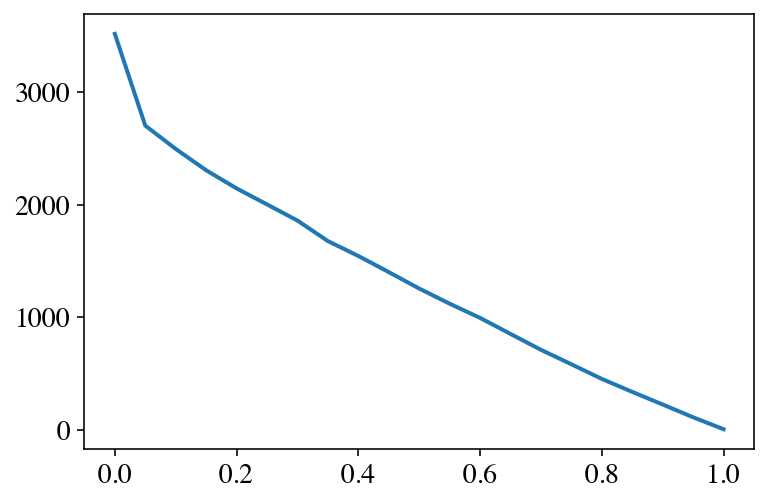

In [18]:
plt.plot(list(comp_merged.keys()), np.array(list(comp_merged.values())))

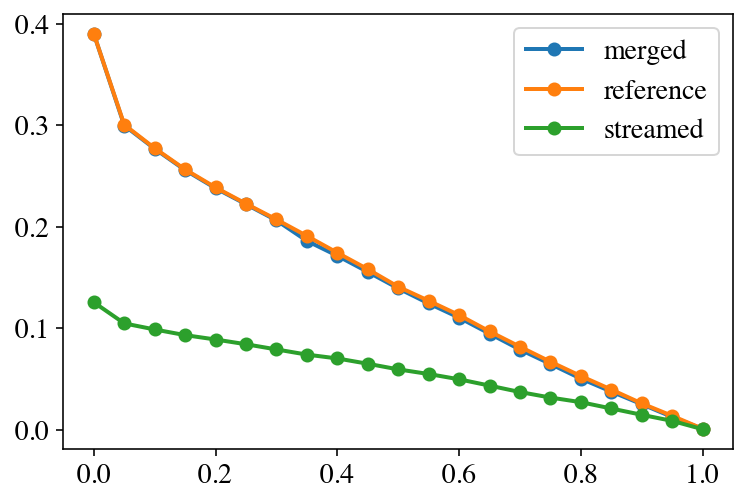

In [20]:
#plt.title('Compresion merged network vs. streamed network')
plt.plot(list(comp_merged.keys()), np.array(list(comp_merged.values()))/size,'-o', label='merged')
#plt.plot(list(comp_ref.keys()), np.array(list(comp_ref.values()))/size,'-o', label='reference')
plt.plot(list(comp_stream.keys()), np.array(list(comp_stream.values()))/size,'-o', label='streamed')

plt.legend();
plt.savefig('../fig/compres.svg', format='svg', bbox_inches = 'tight', dpi=1000)

In [61]:
#comp_merged: 0.65: 853,
#comp_stream: 0.65: 392,

853/size, 392 /size 

(0.09474619571254027, 0.04354104187493058)

In [71]:
with open('../res/stream_2.pickle', 'rb') as f:
    nets_merged = pickle.load(f)

In [72]:
nets_merged[0.0]

{16393: [36, 1279],
 10246: [44, 0],
 14345: [346, 3],
 18442: [17, 0],
 4109: [9, 0],
 18448: [30, 0],
 12305: [0, 57],
 4115: [1, 4],
 16406: [21, 0],
 6166: [10, 0],
 26649: [0, 17],
 2077: [0, 8],
 2094: [0, 27],
 24626: [0, 5],
 2098: [23, 0],
 8244: [0, 29],
 18484: [55, 1],
 18490: [11, 1],
 14394: [0, 8],
 18494: [7, 1],
 22596: [0, 11],
 8272: [8, 0],
 16466: [0, 5],
 22611: [0, 15],
 16469: [0, 7],
 26713: [0, 17],
 6233: [99, 0],
 24666: [4, 50],
 14428: [4, 0],
 16478: [0, 15],
 4190: [134, 0],
 24673: [0, 32],
 4199: [205, 0],
 22631: [0, 20],
 20591: [135, 0],
 14448: [0, 6],
 18545: [20, 0],
 4209: [7, 34],
 26742: [3, 30],
 6265: [24, 0],
 24699: [0, 22],
 16507: [0, 20],
 6267: [1, 2],
 125: [1, 17],
 20605: [14, 0],
 6271: [11, 0],
 8323: [10, 0],
 8324: [21, 0],
 4233: [25, 0],
 22668: [0, 3],
 26768: [1, 15],
 8339: [44, 0],
 24725: [0, 50],
 18588: [5, 0],
 12449: [1, 12],
 2211: [3, 27],
 18598: [22, 0],
 6314: [0, 7],
 180: [9, 0],
 8378: [105, 0],
 186: [23, 0],

In [24]:
ml = dict()
for i in range(0, 4):    
    with open(f"../res/newres/probs-stab-{i}.pickle", 'rb') as f:
        ml[i] = pickle.load(f)

In [25]:
gamma=0.65
res = dict()
for i in range(0, 4):
    probs, true_vals = ml[i][gamma]
    [p1, r1, thresholds] = precision_recall_curve(true_vals, probs)
    auc1 = auc(r1, p1)
    res[i] = [p1, r1, auc1]

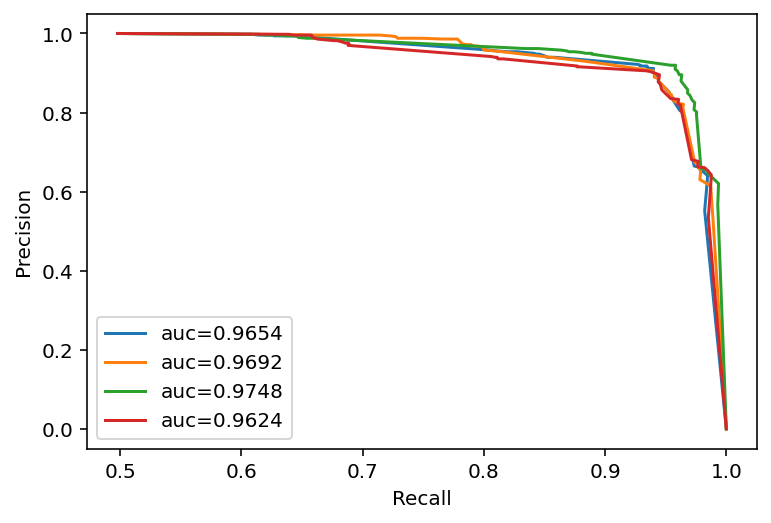

In [26]:
plt.plot(figsize=(12, 8))
#plt.title(f"Stability $\epsilon$={gamma:.2f}")
for i, [p, r, aucs] in res.items():
    plt.plot(p, r, label=f"auc={aucs:.4f}")

plt.legend();
plt.xlabel('Recall')
plt.ylabel('Precision');
plt.savefig('../fig/stab.svg', format='svg', bbox_inches = 'tight', dpi=1000)

## Efficient gammas
For both merged and streamed networks

In [5]:
with open('../res/stream-th15_merged.pickle', 'rb') as f:
    st_m = pickle.load(f)

In [91]:
with open('../res/distances.stream-th15_merged.pickle', 'rb') as f:
    distances_stream = pickle.load(f)

In [77]:
def jaccard(p1, p2) -> float:

    return 1 - len(p1 & p2)/len(p1|p2)

In [21]:
with open('../res/distances.streamed_new.pickle','rb') as f:
    stream_dis = pickle.load(f)

with open('../res/distances.new2_merged.pickle','rb') as f:
    mer_dis = pickle.load(f)

In [22]:
def get_distance_stats(dis):
    re_mm = dict()
    for gamma, vls in dis.items():
        dssts = [dst for _, [dst, anch] in vls.items()]
        if dssts:
            re_mm[gamma] = [max(dssts), np.mean(dssts)]

    return pd.DataFrame.from_dict(re_mm, orient='index', columns=['max', 'mean'])



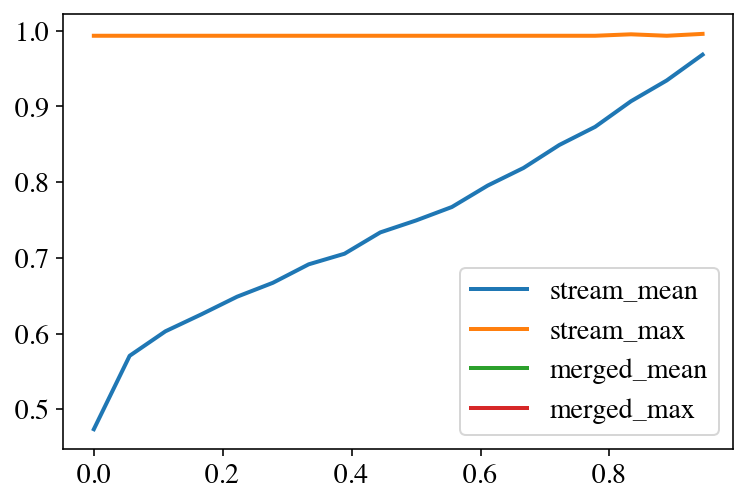

In [23]:
stream_df = get_distance_stats(stream_dis)
merg_df = get_distance_stats(mer_dis)

plt.plot(stream_df['mean'], label='stream_mean')
plt.plot(stream_df['max'], label='stream_max')
plt.plot(merg_df['mean'], label='merged_mean')
plt.plot(merg_df['max'], label='merged_max')
plt.legend();

In [79]:
## new efficient radius

In [37]:
import glob 

def concat_nets(prefix='../res/', wildcard='*-tc-singlereferenceaggregating.pickle'):
    nets = dict()
    for an in glob.glob(wildcard):
        w =an.split('-')[0][len(prefix):]
        gamma = float(w)

        with open(an, 'rb') as f:
            n = pickle.load(f)
        print(gamma, len(n[gamma][0]))
        nets[gamma] = n[gamma][0]
    return nets

In [24]:
with open('../res/distances.streamed_new.pickle','rb') as f:
    stream_dis = pickle.load(f)

with open('../res/distances-newmer.pickle','rb') as f:
    mer_dis = pickle.load(f)

# New Results 
(fixed net creation)

In [25]:
with open('../res/newres/newstream-distances.pickle','rb') as f:
    stream_dis = pickle.load(f)

with open('../res/newres/newmerg-distances.pickle','rb') as f:
    mer_dis = pickle.load(f)

In [26]:
stream_df = get_distance_stats(stream_dis)
merg_df = get_distance_stats(mer_dis)
merg_df.sort_index(inplace=True)


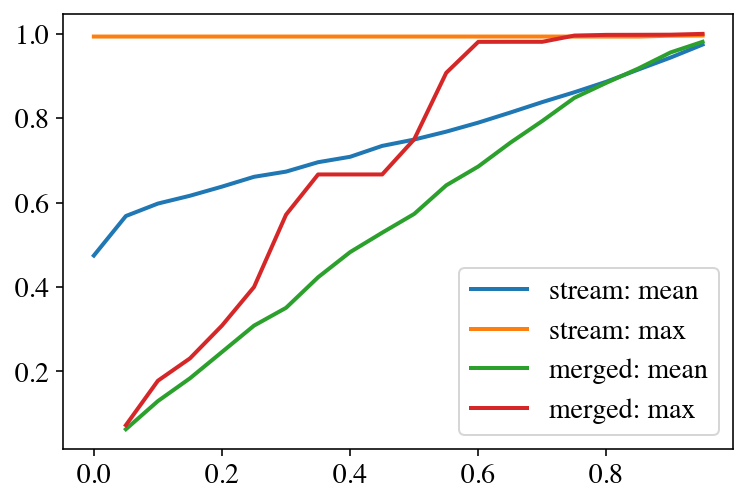

In [27]:
#plt.title('Effective $\epsilon$')
plt.plot(stream_df['mean'], label='stream: mean')
plt.plot(stream_df['max'], label='stream: max')
plt.plot(merg_df['mean'], label='merged: mean')
plt.plot(merg_df['max'], label='merged: max')
plt.legend();

plt.savefig('../fig/eff.svg', format='svg', bbox_inches = 'tight', dpi=1000)

In [ ]:
# Telco todos: 
histogram of minimal distance to the anchors, 
number of misalligned apps
check if this is malicious
90% of others

In [29]:
def get_network(net_file_name):
    print(f"Reading in nets from {net_file_name}")
    with open(net_file_name, 'rb') as f:
        ans = pickle.load(f)
    return ans

In [67]:
! ls ../res/newres/

0.0-stream-singleaggregating.pickle
0.0-tc-singleaggregating.pickle
0.0-tc-singlereferenceaggregating.pickle
0.0-tc-singlevoting.pickle
0.05-stream-singleaggregating.pickle
0.05-tc-singleaggregating.pickle
0.05-tc-singlereferenceaggregating.pickle
0.05-tc-singlevoting.pickle
0.1-stream-singleaggregating.pickle
0.1-tc-singleaggregating.pickle
0.1-tc-singlereferenceaggregating.pickle
0.1-tc-singlevoting.pickle
0.15-stream-singleaggregating.pickle
0.15-tc-singleaggregating.pickle
0.15-tc-singlereferenceaggregating.pickle
0.15-tc-singlevoting.pickle
0.2-stream-singleaggregating.pickle
0.2-tc-singleaggregating.pickle
0.2-tc-singlereferenceaggregating.pickle
0.2-tc-singlevoting.pickle
0.25-stream-singleaggregating.pickle
0.25-tc-singleaggregating.pickle
0.25-tc-singlereferenceaggregating.pickle
0.25-tc-singlevoting.pickle
0.3-stream-singleaggregating.pickle
0.3-tc-singleaggregating.pickle
0.3-tc-singlereferenceaggregating.pickle
0.3-tc-singlevoting.pickle
0.35-stream-singleaggregating.pickle

In [30]:
merged = get_network(net_file_name='../res/newres/new_merged_merged_merged.pickle')
streamed = get_network(net_file_name='../res/newres/new_streamed_mm.pickle')

Reading in nets from ../res/newres/new_merged_merged_merged.pickle
Reading in nets from ../res/newres/new_streamed_mm.pickle


In [103]:
# get misalligned apps

In [31]:
def get_outliers(net, gamma):
    outl = list()
    for an, agg in net.items():
        if not agg:
            continue
        th = [(an, a, distance(a, an)) for a in agg]# if distance(a, an)> gamma]
        outl = outl + th
    return outl

In [32]:
res_mer = dict()
for gamma, net in tqdm(merged.items()):
    res_mer[gamma] = get_outliers(net, gamma)

  0%|          | 0/21 [00:00<?, ?it/s]

In [33]:
res_stream = dict()
for gamma, net in tqdm(streamed.items()):
    res_stream[gamma] = get_outliers(net, gamma)

  0%|          | 0/21 [00:00<?, ?it/s]

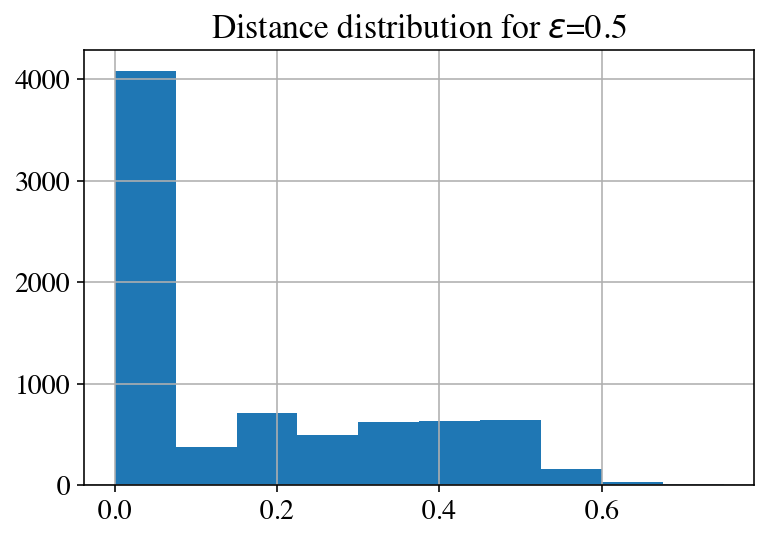

In [35]:
gamma = 0.5
df = pd.DataFrame(res_mer[gamma], columns=['anchor', 'apk', 'distance'])
df.distance.hist(bins=10 )
plt.title(f"Distance distribution for $\epsilon$={gamma}");

TypeError: get_legend_handles_labels() missing 1 required positional argument: 'self'

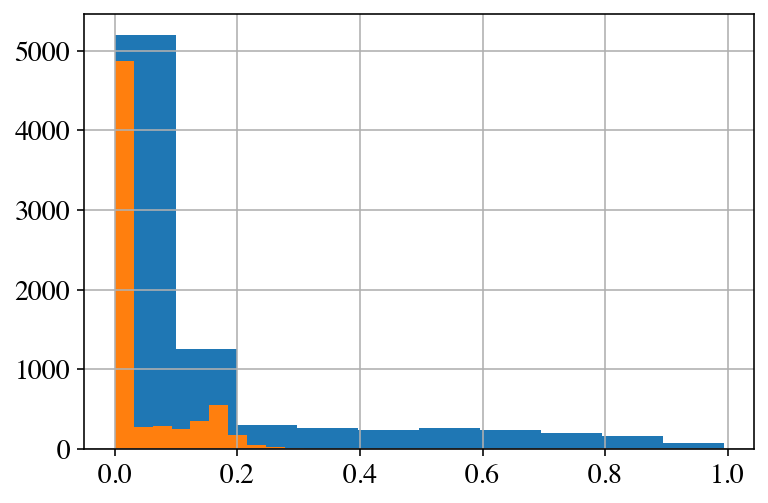

In [121]:
from matplotlib.lines import Line2D

gamma = 0.2

df = pd.DataFrame(res_mer[gamma], columns=['anchor', 'apk', 'distance'])
df2 = pd.DataFrame(res_stream[gamma], columns=['anchor', 'apk', 'distance'])

df2.distance.hist(bins=10, label='streamed')
df.distance.hist(bins=10 , label='merged')

plt.Axes.get_legend_handles_labels()

h1 = Line2D([], [], c='r')
h2 = Line2D([], [], c='b')


plt.legend(handles=[h1, h2], labels=['merged', 'streamed'])
plt.title(f"Distance distribution for $\epsilon$={gamma}");

([], [])

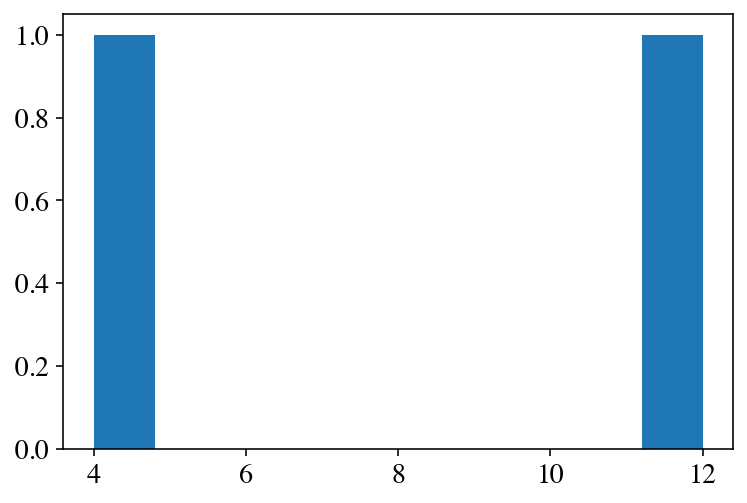

In [128]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist([12, 4])
ax.get_legend_handles_labels()

In [134]:
def plot_distance_distribution(res_mer, res_stream, gamma, bins=10):
    df = pd.DataFrame(res_mer[gamma], columns=['anchor', 'apk', 'distance'])
    df2 = pd.DataFrame(res_stream[gamma], columns=['anchor', 'apk', 'distance'])
    #plt.title(f"Distance distribution $\epsilon$={gamma}");
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    w1 = np.ones_like(df2.distance)/float(len(df2.distance))
    w2 = np.ones_like(df.distance)/float(len(df.distance))
    (n, bins, patches) =ax.hist(df2.distance, bins=bins,weights=w1, histtype='step', label='streamed')
    (n2, bins2, patch3) = ax.hist(df.distance, bins=bins, weights=w2, histtype='step', label='merged')
    plt.xlabel('Distance')
    plt.ylabel('Number of apps (normalized)')
    plt.axvline(x=gamma, ls='--', label='')
    
    handles, labels = ax.get_legend_handles_labels()
    nhand = [Line2D([], [], c=h.get_edgecolor()) for h in handles]
    plt.legend(handles=nhand, labels=labels);

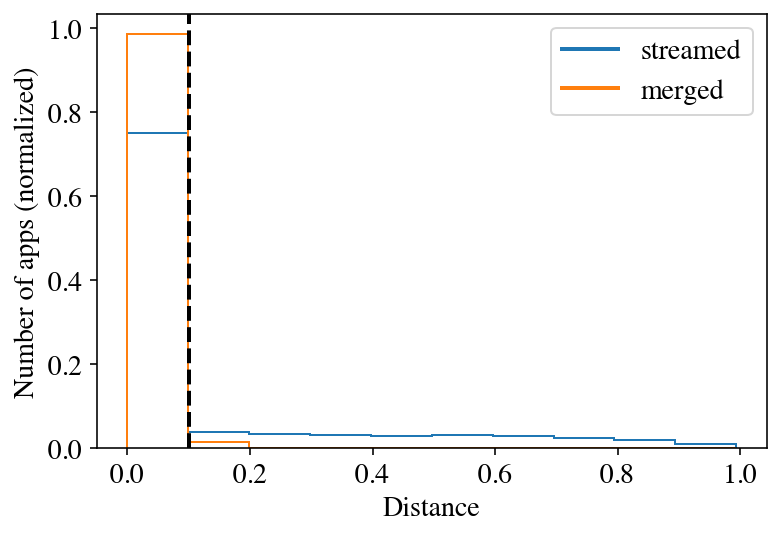

In [135]:
plot_distance_distribution( res_mer=res_mer, res_stream=res_stream, gamma=0.1, bins=10)
plt.savefig('../fig/dist01.svg', format='svg', bbox_inches = 'tight', dpi=1000)

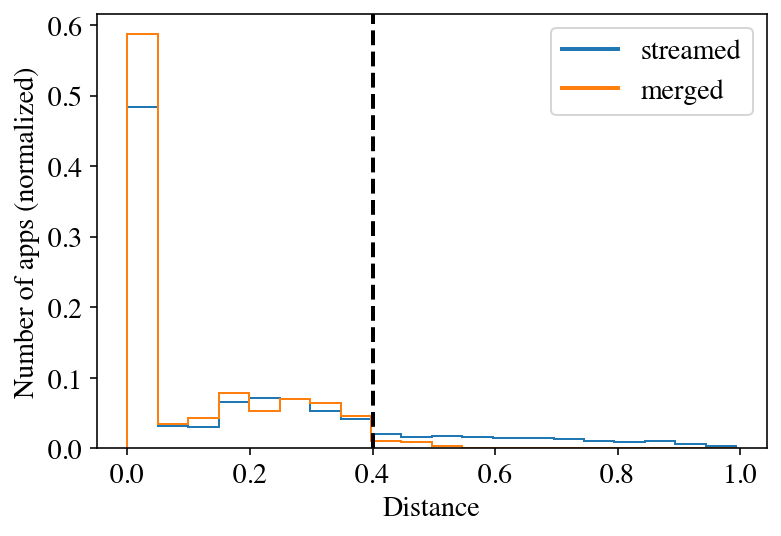

In [136]:
plot_distance_distribution(res_mer=res_mer, res_stream=res_stream, gamma=0.4, bins=20)
plt.savefig('../fig/dist04.svg', format='svg', bbox_inches = 'tight', dpi=1000)

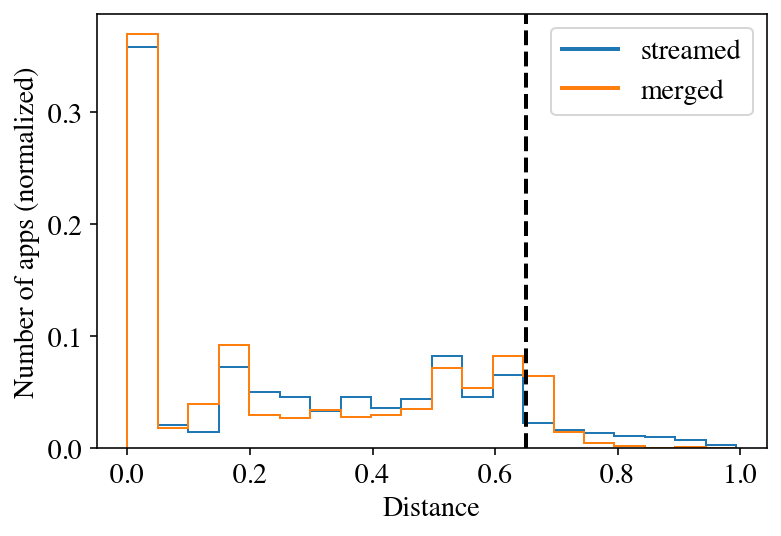

In [137]:
plot_distance_distribution(res_mer=res_mer, res_stream=res_stream, gamma=0.65, bins=20)
plt.savefig('../fig/dist06.svg', format='svg', bbox_inches = 'tight', dpi=1000)

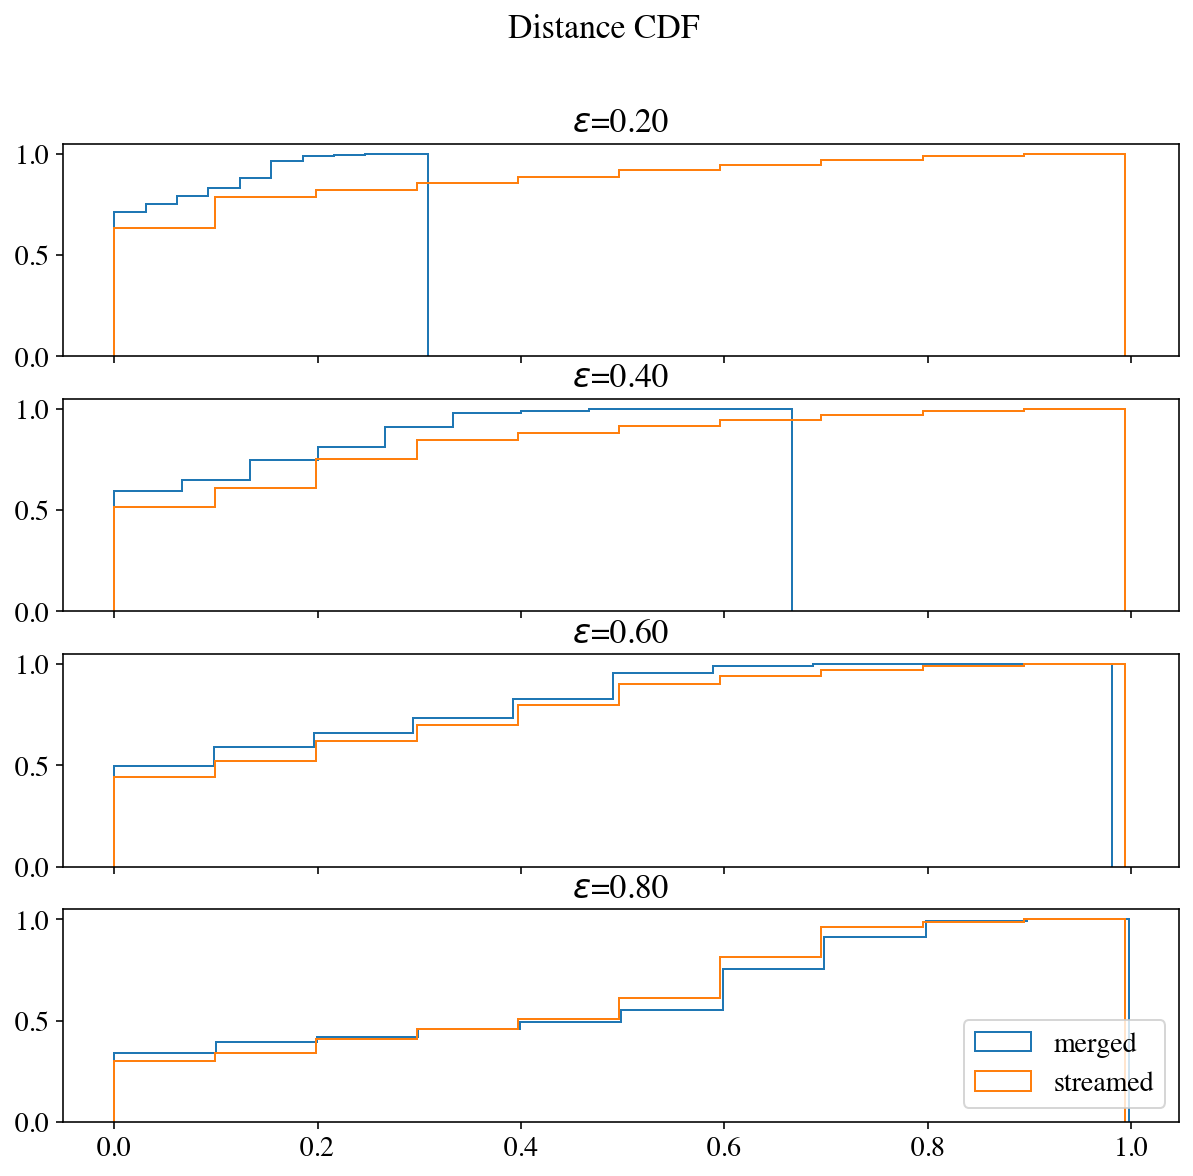

In [55]:
gammas = [0.2, 0.4, 0.6, 0.8]
rows = len(gammas)
cols = 1

fig, axs = plt.subplots(rows, figsize=(10, 9), sharex=True)
fig.suptitle('Distance CDF')
for i, gamma in enumerate(gammas):
    df = pd.DataFrame(res_mer[gamma], columns=['anchor', 'apk', 'distance'])
    df2 = pd.DataFrame(res_stream[gamma], columns=['anchor', 'apk', 'distance'])
    
    axs[i].hist(df['distance'],bins=10, density=True, cumulative=True, histtype='step', label='merged');
    axs[i].hist(df2['distance'], bins=10, density=True, cumulative=True, histtype='step', label='streamed')
    axs[i].set_title(f"$\epsilon$={gamma:.2f} ")

axs[3].legend(loc='lower right');

In [115]:
## New results of distributions

In [116]:
plt.legend?